# LSTM Autoencoder for anomaly detection

This code provides a proof-of-concept of LSTM Autoencoder anomaly detection for gRPC logs from cloud native microservice.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

import os
import pandas as pd
import json
import numpy as np


# Preprosessing

## Extract features from files and make a dataframe

In [ ]:
Unzip data

In [ ]:
import from zipfile import ZipFile

path = os.getcwd()

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(path)

In [3]:
#a help function to import data as dataframes

def import_to_df(folders): 
  
  #preprosess filenames
  filenamessorted = []
  for filename in os.listdir(folder):
      if ("data" not in filename):
          continue
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
        try: 
          entry = json.loads(f.readline())
          filenamessorted.append((filename,entry['timestamp']))
        except:
          continue
  filenamessorted.sort(key=lambda a: a[1])
  files = [t[0] for t in filenamessorted]

  data = []
  errors = 0
  for filename in files:
      file_path = os.path.join(folder, filename)
      with open(file_path) as f:
          # Extract the relevant features from each log entry
          for line in f:
              try:
                  entry = json.loads(line)
                  # Extract the relevant features from the entry and add them to the data list
                  features = {'latency': entry['httpRequest']['latency'],
                              'requestSize': entry['httpRequest']['requestSize'],
                              'requestMethod': entry['httpRequest']['requestMethod'],
                              'responseSize': entry['httpRequest']['responseSize'],
                              'requestUrl': entry['httpRequest']['requestUrl'],
                              'status': entry['httpRequest']['status'],
                              'source_app': entry['labels']['source_app'],
                              'timestamp': entry['timestamp']}
                  data.append(features)
              except json.JSONDecodeError:
                  # Handle JSONDecodeError and continue to the next line
                  errors += 1
                  print(f"Error decoding JSON in file {file_path}: {line}")
                  continue
              except KeyError:
                  # Error and continue to the next line
                  errors += 1
                  print(f"KEY error in file {file_path}: {line}")
                  continue


  # Convert the list of dictionaries into a DataFrame
  print("Number of errors: " + str(errors))
  df = pd.DataFrame(data)

  df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
  df.set_index('timestamp', inplace=True)
  df = df.sort_index()

  dforiginal = df.copy()
  return df, dforiginal


## Import normal data

In [4]:
train_df,train_dforiginal = import_to_df("/data/normal");

train_df.shape

['data000000000018', 'data000000000019', 'data000000000021', 'data000000000020', 'data000000000022', 'data000000000024', 'data000000000023', 'data000000000025', 'data000000000031', 'data000000000026', 'data000000000027', 'data000000000028', 'data000000000029', 'data000000000030', 'data000000000032', 'data000000000033', 'data000000000034', 'data000000000035', 'data000000000036', 'data000000000037', 'data000000000038', 'data000000000039', 'data000000000040']
Number of errors: 0


(834294, 7)

## import test

In [5]:
test_df,test_dforiginal  = import_to_df("/data/anomaly");

test_df.shape

['data-000000000046', 'data-000000000034', 'data-000000000030', 'data-000000000048', 'data-000000000043', 'data-000000000051', 'data-000000000052', 'data-000000000045', 'data-000000000047', 'data-000000000042', 'data-000000000049']
Number of errors: 0


(403497, 7)

## Latency

In the scope of this thesis, the latency values do not need to represent an absolute value but rather an approximate indication of whether they are normal or not. In other words, the objective is to treat the value of latency as a discrete rather than a continuous quantity.

### plot

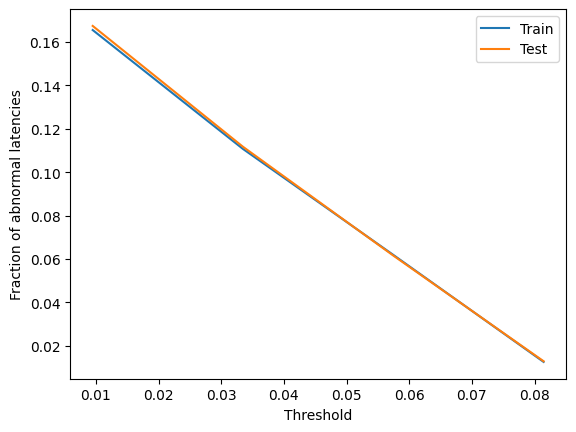

   Threshold  Train Fraction  Test Fraction
0   0.009487        0.165548       0.167446
1   0.033471        0.110739       0.111746
2   0.057456        0.061928       0.061611
3   0.081440        0.012603       0.012920


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


latency_mean = train_df['latency'].mean()
latency_std = train_df['latency'].std()
thresholds = []

for i in range(4):

# Define threshold for abnormal latency as three standard deviations away from the mean of TrainDF
  thresholds.append(latency_mean + i*latency_std)

# Define empty lists to store results
train_labels_list = []
train_fractions_list = []
test_labels_list = []
test_fractions_list = []

# Loop over threshold values
for threshold in thresholds:

    train_df['latency_label'] = np.where(train_df['latency'] > threshold, 1, 0)
    test_df['latency_label'] = np.where(test_df['latency'] > threshold, 1, 0)

    # Compute fraction of abnormal latencies
    train_fraction = train_df['latency_label'].value_counts()[1]/train_df.shape[0]
    test_fraction = test_df['latency_label'].value_counts()[1]/test_df.shape[0]
    #test_fraction = test_df['latency_label'].mean()

    # Append results to lists
    train_labels_list.append(train_df['latency_label'])
    train_fractions_list.append(train_fraction)
    test_labels_list.append(test_df['latency_label'])
    test_fractions_list.append(test_fraction)


# Plot results
plt.plot(thresholds, train_fractions_list, label='Train')
plt.plot(thresholds, test_fractions_list, label='Test')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Fraction of abnormal latencies')
plt.show()

# Create table of results
results = pd.DataFrame({'Threshold': thresholds, 'Train Fraction': train_fractions_list, 'Test Fraction': test_fractions_list})
print(results)


### determine

In [7]:
latency_mean = train_df['latency'].mean()
latency_std = train_df['latency'].std()
latency_threshold = (latency_mean + 1*latency_std)
train_df['latency_label'] = np.where(train_df['latency'] > latency_threshold, 1, 0)
test_df['latency_label'] = np.where(test_df['latency'] > latency_threshold, 1, 0)


## Create keys and dummies

A limited number of combinations in the dataset used in the thesis; hence, one-hot encoding has been applied. This simplifying the interpretation of the data does not lose information but enables future analysis, such as examining the occurrence of specific combinations of logs. We can calculate how many combinations of the selected features exist within the datasets and give them a number, or key, to represent each combination. Specifically, this process first concatenates the training and test datasets to form a combined dataset. By creating keys from the combined datasets, we ensure that all possible variations are considered, including those that may exist in the training or test dataset alone.

In [9]:
# concatenate the dataframes
df_concat = pd.concat([test_df, train_df], axis=0)


# create keys for both dataframes
df_concat['key'] = df_concat.groupby(['latency_label', 'requestSize', 'requestMethod', 'responseSize',
       'requestUrl', 'status', 'source_app'], dropna=False).ngroup()

# get dummies for the 'key' column
df_concat=df_concat[['key']]
df_concat = pd.get_dummies(df_concat, columns=['key'])


# split back into original dataframes
test_df = df_concat.iloc[:len(test_df), :]
train_df = df_concat.iloc[len(test_df):, :]

In [10]:
print(train_df.shape)
print(test_df.shape)

(834294, 615)
(403497, 615)


# AUTOENCODER

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.experimental.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Timeseries

The data is reshaped into sequences with length 𝑙 = 20. This means each sentence given to the model has 𝑙−many logs reprocessed into keys. 

In [11]:
num_steps = 20
features = train_df.shape[1]

In [11]:
train_batches = (train_df.shape[0] // num_steps) * num_steps
train_data = train_df.iloc[:train_batches]

features = train_df.shape[1]
x_train_shaped = np.reshape(train_data.to_numpy(), newshape=(-1, num_steps, features))

Split the normal data into training and predict sets

In [11]:
x_trained_shaped_fit = x_train_shaped[:30000]
x_trained_shaped_predict = x_train_shaped[30000:]

Do the same for the anomaly data, and create the smaller set of the first 25000 samples.

In [12]:
test_df_short = test_df.iloc[:25000]
test_batches = (test_df.shape[0] // num_steps) * num_steps
test_batches_short = (test_df_short.shape[0] // num_steps) * num_steps
test_data = test_df.iloc[:test_batches]
test_data_short = test_df_short.iloc[:test_batches_short]

features = test_df.shape[1]
x_test_shaped = np.reshape(test_data.to_numpy(), newshape=(-1, num_steps, features))
x_test_short_shaped = np.reshape(test_data_short.to_numpy(), newshape=(-1, num_steps, features))


## Define model

This thesis uses deep learning to train a LSTM autoencoder model. Then it uses the model to predict two sets of test data to detect anomalous events, proving the method as a way to secure microservice productions. At the beginning of training, the default values were used for the LSTM autoencoder, namelyh=5,𝑙=10,and𝑏=32. Here,hreferstothenumberoflayersinthe LSTM autoencoder model, and 𝑙 represents the length of a sequence of keys. After this, experiments over different parameters were performed to identify the suitable hyperparameter values for initializing the final model.

In [14]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense


# Define the model 
model = Sequential()

# Encoder
model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(RepeatVector(x_train_shaped.shape[1]))

# Decoder
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           380928    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 20, 615)          79335     
 ibuted)                                                

### Fit

After the model has been set up, the normal training data is fed into the model using the 𝑓 𝑖𝑡 method of the Keras library23, which performs the training process. The input data is provided as both the input and target, as the objective of an autoencoder is to reconstruct the input data. However, early stopping was used by saving the model producing the smallest validation error during the training. 

Epoch 1/250
750/750 [==============================] - 10s 13ms/step - loss: 0.0014 - accuracy: 0.2654 - val_loss: 0.0013 - val_accuracy: 0.2924
Epoch 2/250
750/750 [==============================] - 8s 10ms/step - loss: 0.0013 - accuracy: 0.3400 - val_loss: 0.0012 - val_accuracy: 0.3749
Epoch 3/250
750/750 [==============================] - 7s 10ms/step - loss: 0.0012 - accuracy: 0.3916 - val_loss: 0.0011 - val_accuracy: 0.4110
Epoch 4/250
750/750 [==============================] - 8s 10ms/step - loss: 0.0011 - accuracy: 0.4186 - val_loss: 0.0011 - val_accuracy: 0.4266
Epoch 5/250
750/750 [==============================] - 8s 10ms/step - loss: 0.0011 - accuracy: 0.4345 - val_loss: 0.0011 - val_accuracy: 0.4428
Epoch 6/250
750/750 [==============================] - 7s 10ms/step - loss: 0.0011 - accuracy: 0.4482 - val_loss: 0.0011 - val_accuracy: 0.4568
Epoch 7/250
750/750 [==============================] - 8s 10ms/step - loss: 0.0010 - accuracy: 0.4637 - val_loss: 0.0010 - val_accuracy

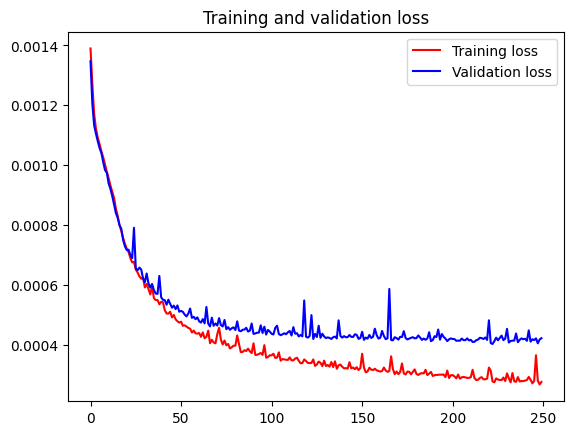

In [18]:
import matplotlib.pyplot as plt

epochs = 250
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

history = model.fit(x_trained_shaped_fit,x_trained_shaped_fit, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

# Plot training and validation loss over epochs
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Print plots for accuracy

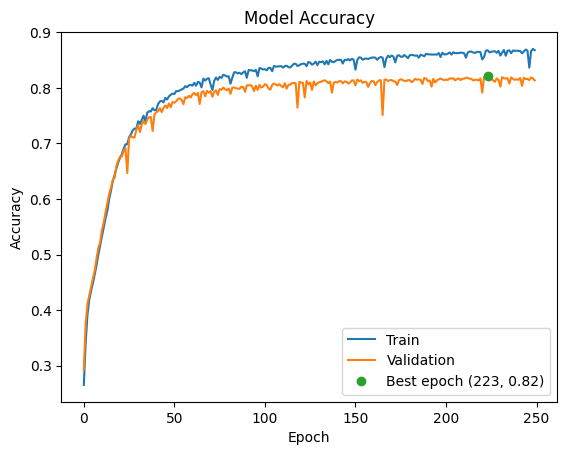

In [19]:
import matplotlib.pyplot as plt

# load the best weights
model.load_weights(checkpoint_filepath)

# Get the value of the validation accuracy at each epoch
val_acc = history.history['val_accuracy']

# Get the epoch with the highest validation accuracy
best_epoch = np.argmax(val_acc)
best_val_acc = val_acc[best_epoch]



# plot accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.plot(best_epoch + 1, best_val_acc, 'o', label=f'Best epoch ({best_epoch + 1}, {best_val_acc:.2f})')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', f'Best epoch ({best_epoch + 1}, {best_val_acc:.2f})'], loc='lower right')
plt.show()


# Predict
Predict the whole normal data and the anomal data twice with different sizes

In [21]:
X_pred = model.predict(x_trained_shaped_predict, batch_size=32)
X_pred_test = model.predict(x_test_shaped,batch_size=32)

631/631 [==============================] - 2s 4ms/step


In [26]:
X_pred_test_short = model.predict(x_test_short_shaped,batch_size=32)
mse_test_short = calc_mse(x_test_short_shaped, X_pred_test_short)

40/40 [==============================] - 0s 4ms/step


# Classify

In [22]:
from sklearn.metrics import mean_squared_error

# Iterate over each sequence in X_train

def calc_mse(X,X_predict):
  mse_list = []
  for i in range(X.shape[0]):
      # Get the current sequence
      sequence = X[i]

      # Calculate the mean squared error for the sequence
      mse = mean_squared_error(sequence, X_predict[i])
      mse_list.append(mse)
  return mse_list

In [25]:
mse_train = calc_mse(x_trained_shaped_predict, X_pred)
mse_test = calc_mse(x_test_shaped, X_pred_test)

In [35]:
model.summary()
x_test_short_shaped.shape

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           380928    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 20, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 20, 615)          79335     
 ibuted)                                                

(1250, 20, 615)

### Scatter plot

In [ ]:
First plot

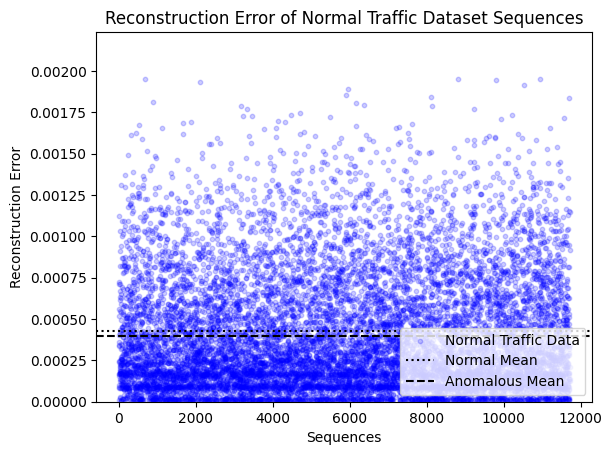

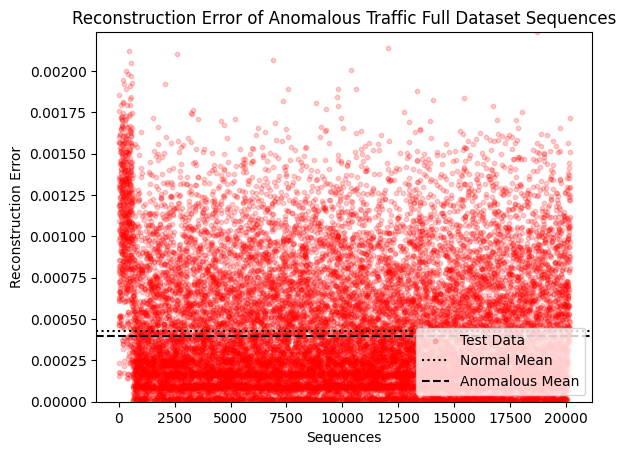

\begin{tabular}{|c|c|c|c|}
\hline
Train Mean & Test Mean & Threshold & Threshold Chosen With \\
\hline
0.00039555958937853575 & 0.0004299309221096337 & 0.001609 & Precision \\
\hline
\end{tabular}\caption(Reconstruction error values of data predicted with model_{30})


In [30]:
import matplotlib.pyplot as plt


# Convert the error values to NumPy arrays
train_errors = np.array(mse_train)
test_errors = np.array(mse_test)


# Generate the x-axis values (running number of the data in order)
x_axis_train = np.arange(len(x_trained_shaped_predict))
x_axis_test = np.arange(len(x_test_shaped))

# Means
train_mean = np.mean(train_errors)
test_mean = np.mean(test_errors)

threshold = 0.001609
threshold_chosen_with = "Precision"
# Create the first plot for train data
plt.figure(1)
plt.scatter(x_axis_train, train_errors, label='Normal Traffic Data', color='blue', s=10, alpha=0.2)
plt.axhline(y=test_mean, color='black', linestyle=':', label='Normal Mean')
plt.axhline(y=train_mean, color='black', linestyle='--', label='Anomalous Mean')
#plt.axhline(y=threshold, color='black', linestyle='-', label='Threshold')
plt.xlabel('Sequences')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Normal Traffic Dataset Sequences')
plt.ylim([0, max(test_errors)])
plt.legend(loc='lower right')

# Create the second plot for test data
plt.figure(2)
plt.scatter(x_axis_test, test_errors, label='Anomalous Data', color='red', s=10, alpha=0.2)
plt.axhline(y=test_mean, color='black', linestyle=':', label='Normal Mean')
plt.axhline(y=train_mean, color='black', linestyle='--', label='Anomalous Mean')
#plt.axhline(y=threshold, color='black', linestyle='-', label='Threshold')
plt.xlabel('Sequences')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Anomalous Traffic Full Dataset Sequences')
plt.ylim([0, max(test_errors)])
plt.legend(loc='lower right')

# Display both plots
plt.show()



# Print the values as a LaTeX table
print(
    "\\begin{tabular}{|c|c|c|c|}\n"
    "\\hline\n"
    "Train Mean & Test Mean & Threshold & Threshold Chosen With \\\\\n"
    "\\hline\n"
    f"{train_mean} & {test_mean} & {threshold} & {threshold_chosen_with} \\\\\n"
    "\\hline\n"
    "\\end{tabular}"
    '''\caption(Reconstruction error values of data predicted with model_{30})'''
)


# Approx the best threshold for the second prediction

In [31]:
import pandas as pd
import numpy as np
def threshold_loop(mse_train,mse_test):
  mean_error = np.mean(mse_train)
  std_error = np.std(mse_train)

  def classify(mse_list, threshold):
    classified = []
    for i in range(len(mse_list)):
      classified.append(0 if mse_list[i] < threshold else 1)
    return classified

  # Set threshold as a certain number of standard deviations from the mean
  std_deviations = [0.1, 0.5, 1, 2, 2.5, 3, 4, 5]
  results = []

  for num_std in std_deviations:
    threshold = mean_error + num_std * std_error
    train_classified = classify(mse_train, threshold)
    test_classified = classify(mse_test, threshold)

    TP = test_classified.count(1)
    FP = train_classified.count(1)
    TN = train_classified.count(0)
    FN = test_classified.count(0)
    try:
      precision = TP / (TP + FP)
      recall = TP / (TP + FN)
      f1_score = 2 * (precision * recall) / (precision + recall)
      accuracy = (TP + TN) / (TP + TN + FP + FN)
      sensitivity = TP / (TP + FN)
      specificity = TN / (TN + FP)

    except Exception as err:
      print(err, num_std)
      continue
    results.append({
        'SDs': num_std,
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    })
  print('True positive: {}, false positive: {}, true negative: {}, false negative{}'.format(TP,FP,TN,FN))
  # Create table of results
  results_df = pd.DataFrame(results)

  return results_df


In [32]:
results_df = threshold_loop(mse_train,mse_test_short)
results_df

float division by zero 5
True positive: 0, false positive: 1, true negative: 11713, false negative1250


,SDs,Threshold,Precision,Recall,F1-score,Accuracy,Sensitivity,Specificity
0,0.1,0.000430,0.160571,0.6392,0.256666,0.643011,0.6392,0.643418
1,0.5,0.000568,0.185264,0.5552,0.277822,0.721691,0.5552,0.739457
2,1.0,0.000741,0.232640,0.4744,0.312187,0.798442,0.4744,0.833020
3,2.0,0.001087,0.343158,0.2608,0.296364,0.880592,0.2608,0.946730
4,2.5,0.001260,0.430255,0.1752,0.249005,0.898102,0.1752,0.975243
5,3.0,0.001433,0.474104,0.0952,0.158561,0.902576,0.0952,0.988731
6,4.0,0.001779,0.529412,0.0144,0.028037,0.903733,0.0144,0.998634


In [ ]:
Second scatter plot, with thresholds

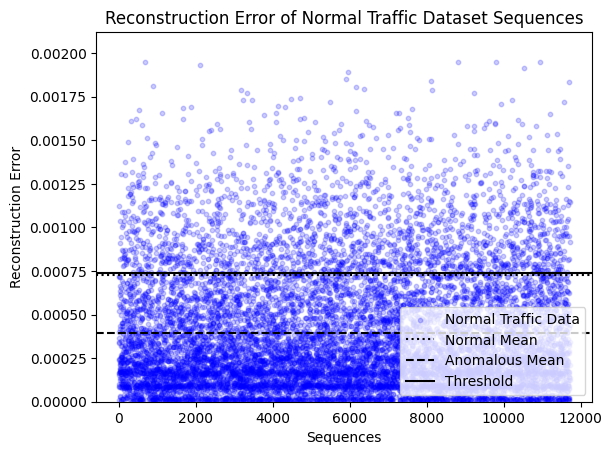

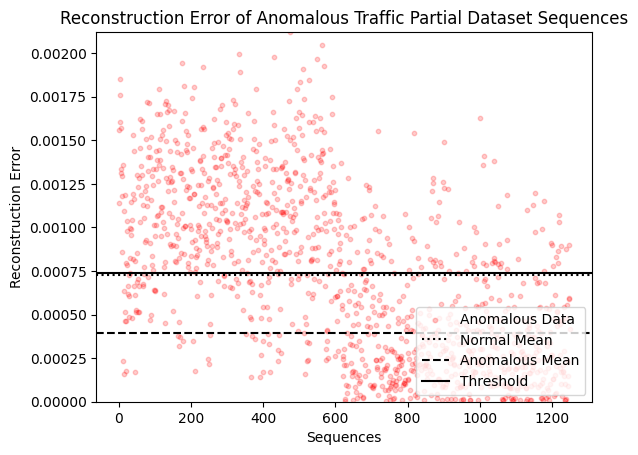

\begin{tabular}{|c|c|c|c|}
\hline
Train Mean & Test_short Mean & Threshold & Threshold Chosen With \\
\hline
0.00039555958937853575 & 0.0007242345600388944 & 0.000741 & F1-score \\
\hline
\end{tabular}\caption(Reconstruction error values of dat)


In [38]:
import matplotlib.pyplot as plt


# Convert the error values to NumPy arrays
train_errors = np.array(mse_train)
test_short_errors = np.array(mse_test_short)


# Generate the x-axis values (running number of the data in order)
x_axis_train = np.arange(len(x_trained_shaped_predict))
x_axis_test_short = np.arange(len(x_test_short_shaped))

# Means
train_mean = np.mean(train_errors)
test_short_mean = np.mean(test_short_errors)

threshold = 0.000741	
threshold_chosen_with = "F1-score"
# Create the first plot for train data
plt.figure(1)
plt.scatter(x_axis_train, train_errors, label='Normal Traffic Data', color='blue', s=10, alpha=0.2)
plt.axhline(y=test_short_mean, color='black', linestyle=':', label='Normal Mean')
plt.axhline(y=train_mean, color='black', linestyle='--', label='Anomalous Mean')
plt.axhline(y=threshold, color='black', linestyle='-', label='Threshold')
plt.xlabel('Sequences')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Normal Traffic Dataset Sequences')
plt.ylim([0, max(test_short_errors)])
plt.legend(loc='lower right')

# Create the second plot for test_short data
plt.figure(2)
plt.scatter(x_axis_test_short, test_short_errors, label='Anomalous Data', color='red', s=10, alpha=0.2)
plt.axhline(y=test_short_mean, color='black', linestyle=':', label='Normal Mean')
plt.axhline(y=train_mean, color='black', linestyle='--', label='Anomalous Mean')
plt.axhline(y=threshold, color='black', linestyle='-', label='Threshold')
plt.xlabel('Sequences')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of Anomalous Traffic Partial Dataset Sequences')
plt.ylim([0, max(test_short_errors)])
plt.legend(loc='lower right')

# Display both plots
plt.show()



# Print the values as a LaTeX table
print(
    "\\begin{tabular}{|c|c|c|c|}\n"
    "\\hline\n"
    "Train Mean & Test_short Mean & Threshold & Threshold Chosen With \\\\\n"
    "\\hline\n"
    f"{train_mean} & {test_short_mean} & {threshold} & {threshold_chosen_with} \\\\\n"
    "\\hline\n"
    "\\end{tabular}"
    '''\caption(Reconstruction error values of dat)'''
)


\begin{tabular}{lrrrrrrrr}\n & SDs & Threshold & Accuracy & Precision & Recall & F1-score & Specificity & FPR \\\\\n0 & 0.1& 0.000359 & 0.644160 & 0.076031 & 0.708000 & 0.137316 & 0.641500 & 0.358500 \\\\\n1 & 0.5& 0.000464 & 0.742208 & 0.094688 & 0.636000 & 0.164835 & 0.746633 & 0.253367 \\\\\n2 & 1.0& 0.000595 & 0.830080 & 0.129156 & 0.565600 & 0.210291 & 0.841100 & 0.158900 \\\\\n3 & 2.0& 0.000858 & 0.928544 & 0.252642 & 0.401600 & 0.310164 & 0.950500 & 0.049500 \\\\\n4 & 3.0& 0.001121 & 0.958432 & 0.463811 & 0.251200 & 0.325895 & 0.987900 & 0.012100 \\\\\n5 & 3.5& 0.001252 & 0.961888 & 0.578249 & 0.174400 & 0.267978 & 0.994700 & 0.005300 \\\\\n6 & 4.0& 0.001384 & 0.962016 & 0.655172 & 0.106400 & 0.183070 & 0.997667 & 0.002333 \\\\\n7 & 4.5& 0.001515 & 0.961440 & 0.727273 & 0.057600 & 0.106746 & 0.999100 & 0.000900 \\\\\n8 & 5.0& 0.001647 & 0.960864 & 0.800000 & 0.028800 & 0.055598 & 0.999700 & 0.000300 \\\\\n
\end{tabular}

# AUTOENCODER AS FUNCTION

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dense

window_results_df = pd.DataFrame(columns=['seq_len', 'best_acc'])

def autoencode(seq_len, epochs):
  
  #print('TRAINDF SHAPE: ' + str(train_df.shape))
  '''preprosses'''
  def shape(df):
    features = train_df.shape[1]
    batches = (df.shape[0] // seq_len) * seq_len
    data = df.iloc[:batches]

    df_shaped = np.reshape(data.to_numpy(), newshape=(-1, seq_len, features))

    return df_shaped


  x_train_shaped = shape(train_df.copy())
  x_test_shaped = shape(test_df.copy())
  #print("X_TRAIN_SHAPED SHAPE: " + str(x_train_shaped.shape))
  '''define model'''
  model = Sequential()

  # Encoder
  model.add(LSTM(128, activation='tanh', input_shape=(x_train_shaped.shape[1],x_train_shaped.shape[2]), return_sequences=True))
  model.add(LSTM(64, activation='tanh', return_sequences=False))
  model.add(RepeatVector(x_train_shaped.shape[1]))

  # Decoder
  model.add(LSTM(64, activation='tanh', return_sequences=True))
  model.add(LSTM(128, activation='tanh', return_sequences=True))
  model.add(TimeDistributed(Dense(x_train_shaped.shape[2])))

  model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
  print("******* SUMMARY WITH SEQ_LEN: " + str(seq_len))
  print(model.summary())

  '''fit'''

  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


  history = model.fit(x_train_shaped,x_train_shaped, epochs=epochs, validation_split=0.2, callbacks=[model_checkpoint_callback])

  # Plot training and validation loss over epochs
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))

  plt.figure()
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss at seq len {}'.format(seq_len))
  plt.legend()
  plt.show()

  ''''pred & results '''

  print("****** PREDICTING *******")
  X_pred = model.predict(x_train_shaped)
  X_pred_test = model.predict(x_test_shaped)
  #model.save('model{}.h5'.format(seq_len))

  #print("****** MSE CALC *******")
  mse_train = calc_mse(x_train_shaped, X_pred)
  mse_test = calc_mse(x_test_shaped, X_pred_test)

  print("****** {} THRESHOLD LOOPING *******".format(seq_len))
  current_results_df = threshold_loop(mse_train,mse_test)

  print("********* RESULTS ********")
  print(current_results_df)
  print("***********")
  
  best_row = current_results_df.iloc[current_results_df['Accuracy'].idxmax()]
  window_results_df.loc[seq_len] = [seq_len, best_row]

  # save the model
  model.save('model{}epoch100.h5'.format(seq_len))
  
  

******* SUMMARY WITH SEQ_LEN: 150
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 150, 128)          349184    
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 150, 64)          0         
 or)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 150, 64)           33024     
                                                                 
 lstm_15 (LSTM)              (None, 150, 128)          98816     
                                                                 
 time_distributed_3 (TimeDis  (None, 150, 553)         71337     
 tributed)          

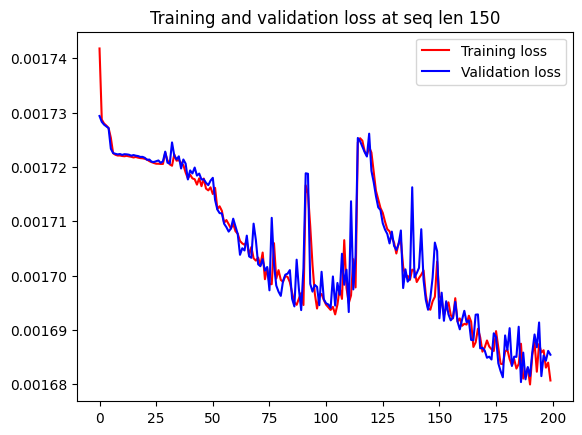

****** PREDICTING *******
21/21 [==============================] - 0s 9ms/step
****** 150 THRESHOLD LOOPING *******
division by zero
division by zero
********* RESULTS ********
    SDs  Threshold  Accuracy  Precision    Recall  F1-score  Specificity  \
0  0.10   0.001688  0.508365   0.234057  0.525915  0.323944     0.503300   
1  0.50   0.001708  0.570843   0.233363  0.400915  0.295008     0.619886   
2  1.00   0.001732  0.692045   0.270522  0.221037  0.243289     0.827981   
3  1.10   0.001737  0.712871   0.255937  0.147866  0.187440     0.875935   
4  1.25   0.001745  0.742574   0.266667  0.085366  0.129330     0.932248   
5  1.30   0.001747  0.754865   0.293333  0.067073  0.109181     0.953366   
6  1.40   0.001752  0.767497   0.352941  0.045732  0.080972     0.975803   
7  1.50   0.001757  0.776033   0.500000  0.028963  0.054755     0.991641   
8  1.75   0.001769  0.776033   0.500000  0.007622  0.015015     0.997800   
9  2.00   0.001782  0.775691   0.333333  0.001524  0.003035    

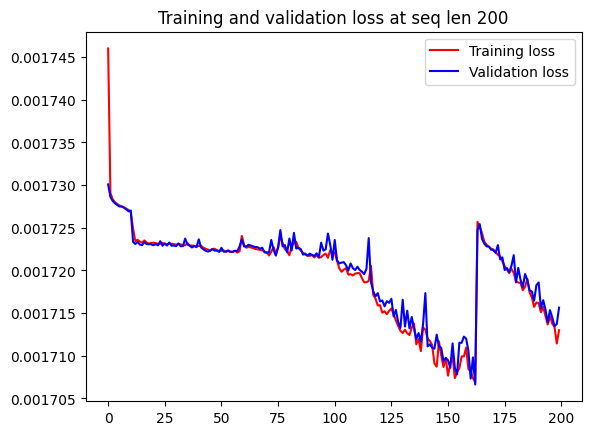

****** PREDICTING *******
16/16 [==============================] - 0s 12ms/step
****** 200 THRESHOLD LOOPING *******
division by zero
division by zero
********* RESULTS ********
    SDs  Threshold  Accuracy  Precision    Recall  F1-score  Specificity  \
0  0.10   0.001717  0.473828   0.221008  0.534553  0.312723     0.456305   
1  0.50   0.001728  0.586709   0.239348  0.388211  0.296124     0.643988   
2  1.00   0.001741  0.709149   0.247423  0.146341  0.183908     0.871554   
3  1.10   0.001744  0.735548   0.274112  0.109756  0.156749     0.916129   
4  1.25   0.001748  0.755576   0.307692  0.073171  0.118227     0.952493   
5  1.30   0.001749  0.762403   0.336957  0.063008  0.106164     0.964223   
6  1.40   0.001751  0.766500   0.327869  0.040650  0.072333     0.975953   
7  1.50   0.001754  0.773327   0.411765  0.028455  0.053232     0.988270   
8  1.75   0.001761  0.776513   0.555556  0.010163  0.019960     0.997654   
9  2.00   0.001767  0.776969   1.000000  0.004065  0.008097   

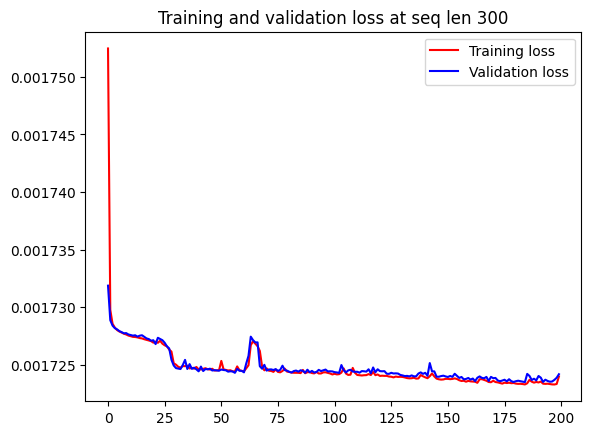

****** PREDICTING *******
11/11 [==============================] - 0s 17ms/step
****** 300 THRESHOLD LOOPING *******
float division by zero
division by zero
********* RESULTS ********
    SDs  Threshold  Accuracy  Precision    Recall  F1-score  Specificity  \
0  0.10   0.001725  0.475410   0.220102  0.527439  0.310592     0.460387   
1  0.50   0.001732  0.591530   0.232143  0.356707  0.281250     0.659331   
2  1.00   0.001740  0.713115   0.270000  0.164634  0.204545     0.871479   
3  1.10   0.001742  0.730874   0.273973  0.121951  0.168776     0.906690   
4  1.25   0.001744  0.753415   0.318681  0.088415  0.138425     0.945423   
5  1.30   0.001745  0.759563   0.333333  0.073171  0.120000     0.957746   
6  1.40   0.001747  0.763661   0.333333  0.054878  0.094241     0.968310   
7  1.50   0.001748  0.770492   0.388889  0.042683  0.076923     0.980634   
8  1.75   0.001752  0.774590   0.437500  0.021341  0.040698     0.992077   
9  2.00   0.001756  0.775273   0.428571  0.009146  0.017

,seq_len,best_row
150,150,SDs 1.500000 Threshold 0.00175...
200,200,SDs 2.000000 Threshold 0.00176...
300,300,SDs 2.000000 Threshold 0.00175...


In [ ]:
window_results_df = pd.DataFrame(columns=['seq_len', 'best_row'])
epochs = 200
for seq_len in [150, 200, 300]:
  autoencode(seq_len, epochs)
window_results_df

In [ ]:
window_results_df.to_csv('5to20.csv')

******* SUMMARY WITH SEQ_LEN: 15
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 15, 128)           352256    
                                                                 
 lstm_41 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector_10 (RepeatVec  (None, 15, 64)           0         
 tor)                                                            
                                                                 
 lstm_42 (LSTM)              (None, 15, 64)            33024     
                                                                 
 lstm_43 (LSTM)              (None, 15, 128)           98816     
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 559)          72111     
 stributed)         

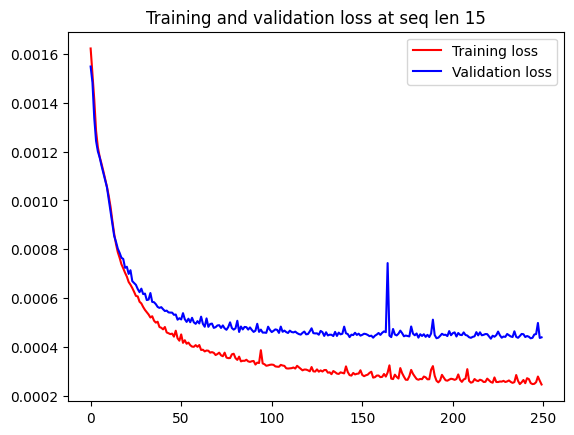

****** PREDICTING *******
408/408 [==============================] - 1s 3ms/step
****** 15 THRESHOLD LOOPING *******


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,seq_len,best_row


In [ ]:
results30_df = pd.DataFrame(columns=['seq_len', 'best_row'])
epochs = 250
for seq_len in [15]:
  autoencode(seq_len, epochs)
results30_df

# Legacy

In [ ]:
TP = test_classified.count(1)
FP = train_classified.count(1)
TN = train_classified.count(0)
FN = test_classified.count(0)

NameError: ignored

In [ ]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
fpr = FP / (TN + FP)


In [ ]:
confusion_matrix = pd.DataFrame(
    {
        '': ['Actual Positive', 'Actual Negative'],
        'Predicted Positive': [TP, FP],
        'Predicted Negative': [FN, TN]
    }
)

# Convert the dataframe to a LaTeX table
confusion_matrix_latex = confusion_matrix.style.to_latex()

# Print the table and the metrics
print(confusion_matrix_latex)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')

\begin{tabular}{llrr}
 &  & Predicted Positive & Predicted Negative \\
0 & Actual Positive & 853 & 147 \\
1 & Actual Negative & 345 & 655 \\
\end{tabular}

Accuracy: 0.75
Precision: 0.71
Recall: 0.85
F1-score: 0.78


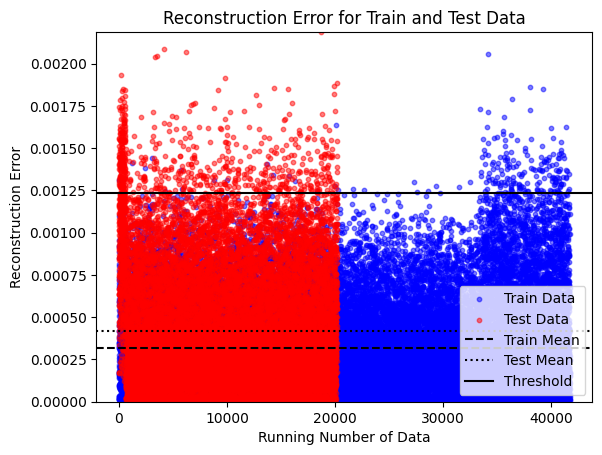

In [ ]:
#LEGACY

import matplotlib.pyplot as plt

# Set the threshold for the reconstruction error to filter out values below 0.001
visual_threshold = 0.000



# Convert the error values to NumPy arrays
train_errors = np.array(mse_train)
test_errors = np.array(mse_test)


# Create a mask to filter the data points based on the visual_threshold
train_mask = train_errors >= visual_threshold
test_mask = test_errors >= visual_threshold

# Generate the x-axis values (running number of the data in order)
x_axis_train = np.arange(len(x_train_shaped))
x_axis_test = np.arange(len(x_test_shaped))


# Means
train_mean = np.mean(train_errors)
test_mean = np.mean(test_errors)



# Plot the reconstruction errors
plt.scatter(x_axis_train[train_mask], train_errors[train_mask], label='Train Data', color='blue', s=10, alpha=0.2)
plt.scatter(x_axis_test[test_mask], test_errors[test_mask], label='Test Data', color='red', s=10, alpha=0.2)

plt.axhline(y=train_mean, color='black', linestyle='--', label='Train Mean')
plt.axhline(y=test_mean, color='black', linestyle=':', label='Test Mean')
plt.axhline(y=0.001355, color='black', linestyle='-', label='Threshold')


# Add labels and title to the plot
plt.xlabel('Running Number of Data')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error for Train and Test Data')

# Set the y-axis limits to show values above the visual_threshold
plt.ylim([visual_threshold, max(max(train_errors), max(test_errors))])


# Add legend to the plot
plt.legend(loc='lower right')

# Display the plot
plt.show()
